In [65]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import json

#  Function to plot interactions with walls and non-self objects.

def plot_all_interactions(game_types, agent_types):
    for game in game_types:
        plot_interaction(game, agent_types)

def plot_interaction(game_type, agent_types):
    w_count = []
    ns_count = []
    for agent in agent_types:
        w, ns = get_interaction_counts(game_type, agent)
        w_count.append(w)
        ns_count.append(ns)

    # Normalize the counts
    normalize(w_count, ns_count)

    #print(game_type, agent_types, "w", w_count)
    #print(game_type, agent_types, "ns", ns_count)

    labels = agent_types
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    wall = ax.bar(x - width/2, w_count, width, label='Wall')
    non_self = ax.bar(x + width/2, ns_count, width, label='Non-self')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Interaction Count (Normalized)')
    ax.set_title( game_type )
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()
    plt.show()

def get_interaction_counts(game_type, agent_type):
    files = glob.glob("../data/" + game_type + "/" + agent_type + "/*.json")
    w_count = 0
    ns_count = 0
    for file in files:
        data = json.load(open(file))
        wall_interactions = data.get("data")["wall_interactions"]
        ns_interactions = data.get("data")["ns_interactions"]
        w_count += sum(wall_interactions)
        ns_count += sum(ns_interactions)

    return w_count, ns_count

def normalize(w, ns):
    for i in range(len(w)):
        w_c = w[i]
        ns_c = ns[i]
        sum = w_c + ns_c
        if sum == 0:
            continue
        w[i] = w_c / sum
        ns[i] = ns_c / sum


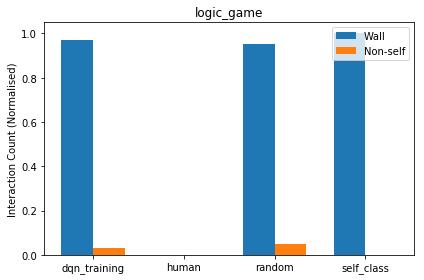

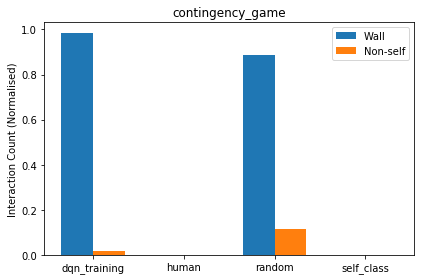

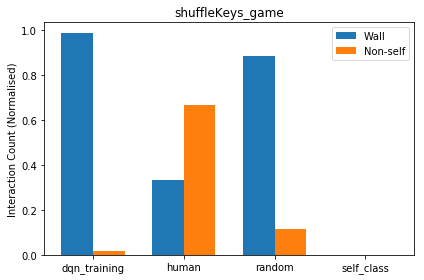

In [66]:
game_types = ["logic_game", "contingency_game", "shuffleKeys_game"]
agent_types = ["dqn_training", "human", "random", "self_class"]

# Plot interaction frequencies for each game and agent.
plot_all_interactions(game_types, agent_types)

In [67]:
# Function to plot bar chart for total steps.

def plot_all_total_steps(game_types, agent_types):
    for game in game_types:
        plot_total_steps(game, agent_types)

def plot_total_steps(game_type, agent_types):
    total = []
    for agent in agent_types:
        ts = get_total_steps(game_type, agent)
        total.append(ts)

    labels = agent_types
    x = np.arange(len(labels))  # the label locations
    width = 0.5  # the width of the bars

    fig, ax = plt.subplots()
    ts = ax.bar(x, total, width)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Total Steps')
    ax.set_title( game_type )
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(ts)

    fig.tight_layout()
    plt.show()

def get_total_steps(game_type, agent_type):
    files = glob.glob("../data/" + game_type + "/" + agent_type + "/*.json")
    count = 0
    for file in files:
        data = json.load(open(file))
        step_counts = data.get("data")["steps"]
        count += sum(step_counts)

    return count

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


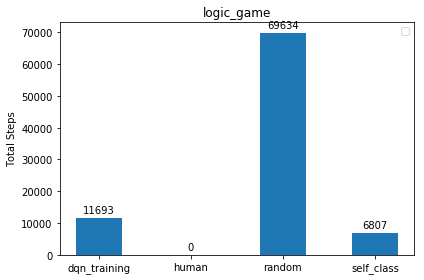

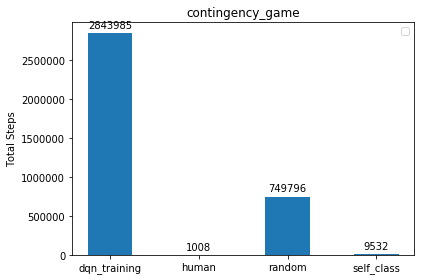

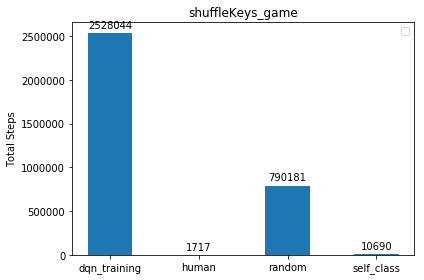

In [68]:
game_types = ["logic_game", "contingency_game", "shuffleKeys_game"]
agent_types = ["dqn_training", "human", "random", "self_class"]

# Plot interaction frequencies for each game and agent.
plot_all_total_steps(game_types, agent_types)
